In [66]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [67]:
train_annotation_file = 'task1/train_data/annotations.csv'
train_img_labeled_dir = 'images/labeled/'
train_img_unlabeled_dir = 'task1/train_data/images/unlabeled/'

val_img_dir = 'task1/val_data/'

In [68]:
df = pd.read_csv(train_annotation_file)

In [69]:
df.head()

,sample,label
0,task1/train_data/images/labeled/0.jpeg,0
1,task1/train_data/images/labeled/1.jpeg,1
2,task1/train_data/images/labeled/2.jpeg,2
3,task1/train_data/images/labeled/3.jpeg,3
4,task1/train_data/images/labeled/4.jpeg,4


In [70]:
print("Number of rows in the training dataset: ",df.shape[0])
print("Number of classes: ", df['label'].nunique())
print("Percentage of each class in the training dataset:\n\n",df['label'].value_counts()*100/df.shape[0])

Number of rows in the training dataset:  23555
Number of classes:  100
Percentage of each class in the training dataset:

 label
52    1.226916
5     1.226916
3     1.214180
8     1.188707
82    1.188707
        ...   
83    0.721715
75    0.708979
92    0.662280
89    0.632562
96    0.318404
Name: count, Length: 100, dtype: float64


In [71]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [72]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # le decomentam ptr train
    transforms.RandomRotation(degrees=15), # le decomentam ptr train
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),

])

In [73]:
class AAITDataset(Dataset):
    def __init__(self, dataset, img_dir, is_train=True, transform=None, target_transform=None):
        self.is_train = is_train
        if self.is_train:
            self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.is_train:
            return len(self.img_labels)
        else:
            self.img_files = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
            return len(self.img_files)

    def __getitem__(self, idx):
        if self.is_train:
            img_path = self.img_labels.iloc[idx, 0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            #print(image)
            if image.size()[0] == 1:
                image = image.expand(3, -1, -1)
            label = self.img_labels.iloc[idx, 1]
            
            if self.target_transform:
                label = self.target_transform(label)
            return image, label, img_path
        else: 
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if image.size(0) == 1:
                image = image.expand(3, -1, -1)
            
            return image, img_path

In [74]:
train_dataset = AAITDataset(train_data, train_img_labeled_dir, is_train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = AAITDataset(test_data, train_img_labeled_dir, is_train=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


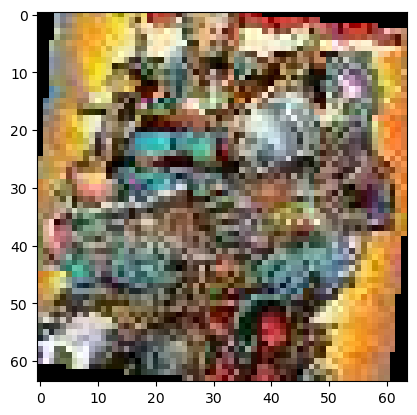

Label: 5


In [75]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 64, 64])


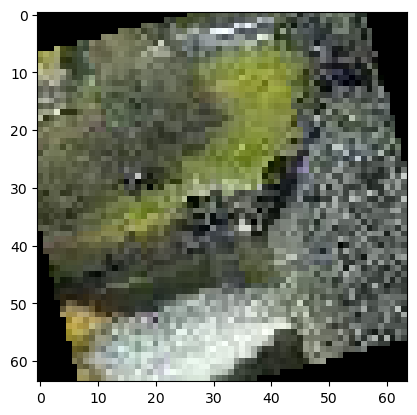

In [76]:
train_features, _ = next(iter(train_unlabeled_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [77]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)
else:
    print("MPS not found!")

mps


In [78]:
%%time
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CustomModel, self).__init__()

        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2")

        num_features = self.resnet50.fc.in_features
        self.dropout = nn.Dropout(p=0.1)
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, num_classes)
        )
        #self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        # Forward pass through the network
        return self.resnet50(x)


model = CustomModel(num_classes=100, pretrained=True).to(mps_device)

def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels, _ in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, train_dataloader, criterion, optimizer, epochs=30, device=mps_device)
avg_loss, acc, prec, rec, f1 = evaluate_model(model, test_dataloader, criterion, mps_device)
print("Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)

100%|██████████| 295/295 [00:24<00:00, 12.12it/s]


Epoch 1/30, Loss: 4.4366, Accuracy: 10.38%


100%|██████████| 295/295 [00:22<00:00, 13.13it/s]


Epoch 2/30, Loss: 3.0948, Accuracy: 38.96%


100%|██████████| 295/295 [00:25<00:00, 11.39it/s]


Epoch 3/30, Loss: 1.8791, Accuracy: 55.09%


100%|██████████| 295/295 [00:38<00:00,  7.60it/s]


Epoch 4/30, Loss: 1.4554, Accuracy: 62.85%


100%|██████████| 295/295 [00:58<00:00,  5.02it/s]


Epoch 5/30, Loss: 1.2331, Accuracy: 67.73%


100%|██████████| 295/295 [00:57<00:00,  5.10it/s]


Epoch 6/30, Loss: 1.0935, Accuracy: 71.24%


100%|██████████| 295/295 [00:58<00:00,  5.05it/s]


Epoch 7/30, Loss: 0.9600, Accuracy: 74.15%


100%|██████████| 295/295 [00:58<00:00,  5.02it/s]


Epoch 8/30, Loss: 0.8642, Accuracy: 76.36%


100%|██████████| 295/295 [00:58<00:00,  5.07it/s]


Epoch 9/30, Loss: 0.7772, Accuracy: 78.64%


100%|██████████| 295/295 [00:57<00:00,  5.13it/s]


Epoch 10/30, Loss: 0.7064, Accuracy: 80.37%


100%|██████████| 295/295 [00:56<00:00,  5.23it/s]


Epoch 11/30, Loss: 0.6337, Accuracy: 82.54%


100%|██████████| 295/295 [00:56<00:00,  5.22it/s]


Epoch 12/30, Loss: 0.5812, Accuracy: 83.69%


100%|██████████| 295/295 [00:55<00:00,  5.34it/s]


Epoch 13/30, Loss: 0.5233, Accuracy: 85.15%


100%|██████████| 295/295 [00:59<00:00,  5.00it/s]


Epoch 14/30, Loss: 0.4781, Accuracy: 86.77%


100%|██████████| 295/295 [00:56<00:00,  5.20it/s]


Epoch 15/30, Loss: 0.4314, Accuracy: 87.64%


100%|██████████| 295/295 [00:57<00:00,  5.09it/s]


Epoch 16/30, Loss: 0.3850, Accuracy: 89.12%


100%|██████████| 295/295 [00:57<00:00,  5.09it/s]


Epoch 17/30, Loss: 0.3564, Accuracy: 90.02%


100%|██████████| 295/295 [00:59<00:00,  4.97it/s]


Epoch 18/30, Loss: 0.3206, Accuracy: 91.01%


100%|██████████| 295/295 [00:58<00:00,  5.07it/s]


Epoch 19/30, Loss: 0.2902, Accuracy: 91.71%


100%|██████████| 295/295 [00:55<00:00,  5.28it/s]


Epoch 20/30, Loss: 0.2699, Accuracy: 92.34%


100%|██████████| 295/295 [00:54<00:00,  5.40it/s]


Epoch 21/30, Loss: 0.2363, Accuracy: 93.31%


100%|██████████| 295/295 [00:55<00:00,  5.34it/s]


Epoch 22/30, Loss: 0.2169, Accuracy: 94.08%


100%|██████████| 295/295 [00:53<00:00,  5.46it/s]


Epoch 23/30, Loss: 0.1944, Accuracy: 94.42%


100%|██████████| 295/295 [00:55<00:00,  5.35it/s]


Epoch 24/30, Loss: 0.1774, Accuracy: 95.02%


100%|██████████| 295/295 [00:55<00:00,  5.27it/s]


Epoch 25/30, Loss: 0.1546, Accuracy: 95.66%


100%|██████████| 295/295 [00:54<00:00,  5.37it/s]


Epoch 26/30, Loss: 0.1459, Accuracy: 96.09%


100%|██████████| 295/295 [00:56<00:00,  5.25it/s]


Epoch 27/30, Loss: 0.1361, Accuracy: 96.17%


100%|██████████| 295/295 [00:56<00:00,  5.23it/s]


Epoch 28/30, Loss: 0.1286, Accuracy: 96.42%


100%|██████████| 295/295 [00:55<00:00,  5.33it/s]


Epoch 29/30, Loss: 0.1138, Accuracy: 96.93%


100%|██████████| 295/295 [00:56<00:00,  5.24it/s]


Epoch 30/30, Loss: 0.1039, Accuracy: 97.18%
Results:
Average loss:  1.3296274832777075
Accuracy:  71.30120993419656
Precision:  71.89524003506284
Recall:  71.30120993419656
F1 score:  71.30472438666798
CPU times: user 11min 56s, sys: 1min 26s, total: 13min 23s
Wall time: 26min 35s


In [79]:
def generate_pseudo_labels(model, dataloader):
    model.eval()
    pseudo_label_data = []
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(mps_device)
            outputs = model(images)
            probs, predicted = torch.max(outputs, 1)
            
            
            for img_path, label in zip(img_paths, predicted):
                pseudo_label_data.append((img_path, label.item()))

    pseudo_labels_df = pd.DataFrame(pseudo_label_data, columns=['sample', 'label'])
    return pseudo_labels_df



In [80]:
val_unlabeled_dataset = AAITDataset(None, val_img_dir, is_train=False, transform=transform)
val_unlabeled_dataloader = DataLoader(val_unlabeled_dataset, batch_size=64, shuffle=False)

val_labels = generate_pseudo_labels(model, val_unlabeled_dataloader)
val_labels['sample'] = val_labels['sample'].apply(lambda x: x.split('/')[-1])


In [81]:
val_labels['sort_key'] = val_labels['sample'].str.extract('(\d+)').astype(int)
val_labels.sort_values(by='sort_key', ascending=True, inplace=True)
val_labels.reset_index(inplace=True)
val_labels.drop(columns=['sort_key','index'], inplace=True)

val_labels.to_csv('task1/baseline.csv', index=False)

# Employing EfficientNetB0

In [84]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

num_classes=100

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)
model_efficientnet = model_efficientnet.to(mps_device)

In [85]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(model_efficientnet.parameters(), lr=0.001, momentum=0.9)
train_model(model_efficientnet, train_dataloader, criterion, optimizer, epochs=30, device=mps_device)
avg_loss, acc, prec, rec, f1 = evaluate_model(model_efficientnet, test_dataloader, criterion, mps_device)
print("Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)

100%|██████████| 295/295 [00:37<00:00,  7.87it/s]


Epoch 1/30, Loss: 4.4865, Accuracy: 4.13%


100%|██████████| 295/295 [00:37<00:00,  7.82it/s]


Epoch 2/30, Loss: 3.8944, Accuracy: 16.82%


100%|██████████| 295/295 [00:36<00:00,  8.09it/s]


Epoch 3/30, Loss: 3.2529, Accuracy: 27.97%


100%|██████████| 295/295 [00:35<00:00,  8.20it/s]


Epoch 4/30, Loss: 2.7625, Accuracy: 35.73%


100%|██████████| 295/295 [00:36<00:00,  8.16it/s]


Epoch 5/30, Loss: 2.4295, Accuracy: 40.97%


100%|██████████| 295/295 [00:35<00:00,  8.20it/s]


Epoch 6/30, Loss: 2.1997, Accuracy: 45.44%


100%|██████████| 295/295 [00:36<00:00,  8.14it/s]


Epoch 7/30, Loss: 2.0290, Accuracy: 48.87%


100%|██████████| 295/295 [00:36<00:00,  8.12it/s]


Epoch 8/30, Loss: 1.8939, Accuracy: 51.83%


100%|██████████| 295/295 [00:36<00:00,  8.19it/s]


Epoch 9/30, Loss: 1.7721, Accuracy: 54.37%


100%|██████████| 295/295 [00:36<00:00,  8.16it/s]


Epoch 10/30, Loss: 1.6583, Accuracy: 56.43%


100%|██████████| 295/295 [00:32<00:00,  9.09it/s]


Epoch 11/30, Loss: 1.5778, Accuracy: 58.77%


100%|██████████| 295/295 [00:28<00:00, 10.20it/s]


Epoch 12/30, Loss: 1.5050, Accuracy: 60.24%


100%|██████████| 295/295 [00:28<00:00, 10.36it/s]


Epoch 13/30, Loss: 1.4296, Accuracy: 62.25%


100%|██████████| 295/295 [00:28<00:00, 10.32it/s]


Epoch 14/30, Loss: 1.3756, Accuracy: 63.50%


100%|██████████| 295/295 [00:28<00:00, 10.41it/s]


Epoch 15/30, Loss: 1.3022, Accuracy: 65.16%


100%|██████████| 295/295 [00:28<00:00, 10.28it/s]


Epoch 16/30, Loss: 1.2515, Accuracy: 66.29%


100%|██████████| 295/295 [00:28<00:00, 10.39it/s]


Epoch 17/30, Loss: 1.1959, Accuracy: 67.68%


100%|██████████| 295/295 [00:28<00:00, 10.22it/s]


Epoch 18/30, Loss: 1.1513, Accuracy: 68.35%


100%|██████████| 295/295 [00:28<00:00, 10.30it/s]


Epoch 19/30, Loss: 1.0985, Accuracy: 70.08%


100%|██████████| 295/295 [00:28<00:00, 10.26it/s]


Epoch 20/30, Loss: 1.0483, Accuracy: 71.19%


100%|██████████| 295/295 [00:28<00:00, 10.41it/s]


Epoch 21/30, Loss: 1.0112, Accuracy: 72.03%


100%|██████████| 295/295 [00:28<00:00, 10.29it/s]


Epoch 22/30, Loss: 0.9713, Accuracy: 73.33%


100%|██████████| 295/295 [00:28<00:00, 10.42it/s]


Epoch 23/30, Loss: 0.9291, Accuracy: 74.67%


100%|██████████| 295/295 [00:28<00:00, 10.30it/s]


Epoch 24/30, Loss: 0.9103, Accuracy: 74.53%


100%|██████████| 295/295 [00:28<00:00, 10.42it/s]


Epoch 25/30, Loss: 0.8618, Accuracy: 76.25%


100%|██████████| 295/295 [00:28<00:00, 10.31it/s]


Epoch 26/30, Loss: 0.8247, Accuracy: 77.27%


100%|██████████| 295/295 [00:28<00:00, 10.40it/s]


Epoch 27/30, Loss: 0.7922, Accuracy: 77.83%


100%|██████████| 295/295 [00:28<00:00, 10.29it/s]


Epoch 28/30, Loss: 0.7726, Accuracy: 78.48%


100%|██████████| 295/295 [00:28<00:00, 10.43it/s]


Epoch 29/30, Loss: 0.7331, Accuracy: 79.62%


100%|██████████| 295/295 [00:28<00:00, 10.34it/s]


Epoch 30/30, Loss: 0.6977, Accuracy: 80.59%
Results:
Average loss:  1.5858006670668319
Accuracy:  60.517936743791125
Precision:  60.69685739618967
Recall:  60.517936743791125
F1 score:  60.234790630751135
